<a href="https://colab.research.google.com/github/klopetx/PHM_tutorial/blob/main/src/03_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

project_path = 'PHM_tutorial'

if not os.path.isdir(project_path):

  username = 'klopetx'
  repo = project_path

  !git clone https://@github.com/{username}/{repo}

os.chdir(project_path)

!python src/00_Environment_Checks.py

indicator_file_path = "data/indicators.csv"

if not os.path.isdir(project_path):
  print('Indicator dataset not found, extracting indicators...')
  !python src/01_Indicator_extraction.py
  print('Indicators extracted succesfully!')

import sys
sys.path.append('src')
import feature_selection_auxiliars as FS_aux

FEMTO dataset is already downloaded.
Indicator dataset not found, extracting indicators...
Indicators extracted succesfully!


# Feature selection

When the amount of indicators/features/kpi-s we are working with is big it is sometimes difficult to guarantee that they are all relevant for our purposes. That is why we employ feature selection techniques: to remove features that do not clearly contribute to approximating our problem at hand.





## The dataset

We have now a dataset which has some indicators extracted from each raw signal and, in addition, the time to failure has been included.

Let's load it an have a look:

In [ ]:
import pandas as pd
import numpy as np

indicators = pd.read_csv( "data/indicators.csv", sep = '\t')
indicators.head()

,Origin,Bearing,OperatingCondition,TestNumber,TestIdx,Hour,Minute,Second,Mili/centisecond,Mean,...,BPFO_rms,BPFI_max,BPFI_rms,BSF_max,BSF_rms,Timestamp,Duration,Actual_RUL,RUL,Alive
0,Full_Test_Set,Bearing2_4,2,4,1,8,3,36,462540.0,0.006552,...,3.462482,2.702957,2.455653,15.180564,13.488451,2000-01-01 08:03:36,0.0,1390,1390.0,True
1,Full_Test_Set,Bearing2_4,2,4,2,8,3,46,462540.0,0.001299,...,5.925823,5.629765,4.592479,18.305801,13.007734,2000-01-01 08:03:46,10.0,1390,1380.0,True
2,Full_Test_Set,Bearing2_4,2,4,3,8,3,56,462540.0,0.003271,...,3.938765,6.103561,4.583218,9.434037,8.430699,2000-01-01 08:03:56,20.0,1390,1370.0,True
3,Full_Test_Set,Bearing2_4,2,4,4,8,4,6,462540.0,0.003263,...,2.652722,6.837217,6.077246,13.578691,10.908141,2000-01-01 08:04:06,30.0,1390,1360.0,True
4,Full_Test_Set,Bearing2_4,2,4,5,8,4,16,462540.0,0.004246,...,3.710252,8.133538,6.903766,12.933754,9.514291,2000-01-01 08:04:16,40.0,1390,1350.0,True


In [ ]:
indicators.columns

Index(['Origin', 'Bearing', 'OperatingCondition', 'TestNumber', 'TestIdx',
       'Hour', 'Minute', 'Second', 'Mili/centisecond', 'Mean',
       'Standard Deviation', 'RMS', 'Peak', 'Peak-to-Peak', 'Skewness',
       'Kurtosis', 'Crest Factor', 'Form Factor', 'Impulse Factor',
       'Margin Factor', 'Total Energy', 'Max Power Frequency',
       'Spectral Centroid', 'Spectral Bandwidth', 'Spectral Flatness',
       'Spectral Roll-off', 'BPFO_max', 'BPFO_rms', 'BPFI_max', 'BPFI_rms',
       'BSF_max', 'BSF_rms', 'Timestamp', 'Duration', 'Actual_RUL', 'RUL',
       'Alive'],
      dtype='object')

Use the following chunk to visualize some of the variables, pay spetial attention to RUL (Remaining Useful Life).

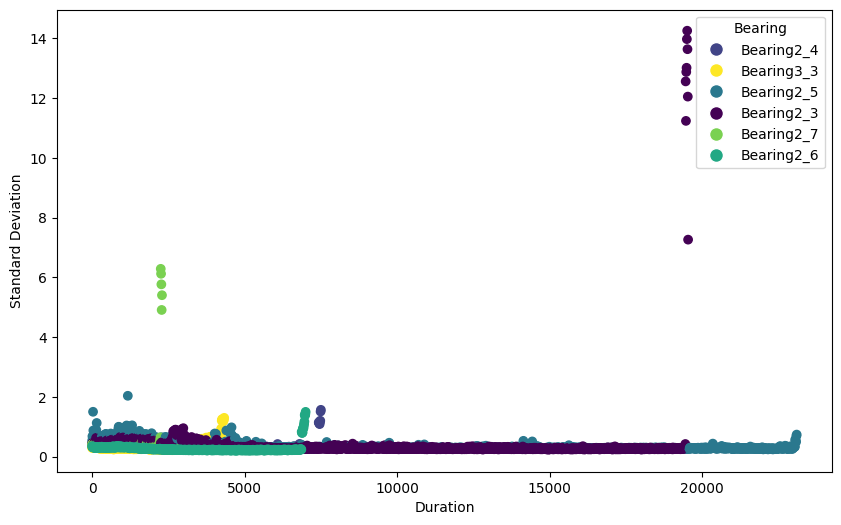

In [ ]:

target_variable = 'Standard Deviation' # select one from indicators.columns

FS_aux.plot_indicator_by_bearing(indicators, target_variable)

The RUL has been added based on the documentation of the dataset. RUL reflects the time left until the machine is no longer operative. According to the people who carried out the experiment, a the  point at which the RUL is equal to 0 or a negative value the machine cannot be considered to be working properly.

We will call RUL the **target variable** that is, the variable we want to infer from the remaining variables.

Use plot_indicator_by_bearing to plot the RUL indicator and answer the following questions:

### Questions


1.   Do all tested bearings last the same?

2.   Does it make sense to include the period after 0 RUL is reached in the analysis?

## Variables of interest

For modelling purposes, we would ideally have a variable (or more) that would behave similarly to the RUL that is, a variable (of set of variables) that correlate well with the RUL indicator.

The question is, how do we know that?

One way would be by visually assessing wether there is any indicator that has similar behaviour as the RUL.

But first, let's remove the datapoints in which the RUL is 0 or negative:


In [ ]:
indicators_alive = indicators.loc[indicators['Alive'] == True].copy()

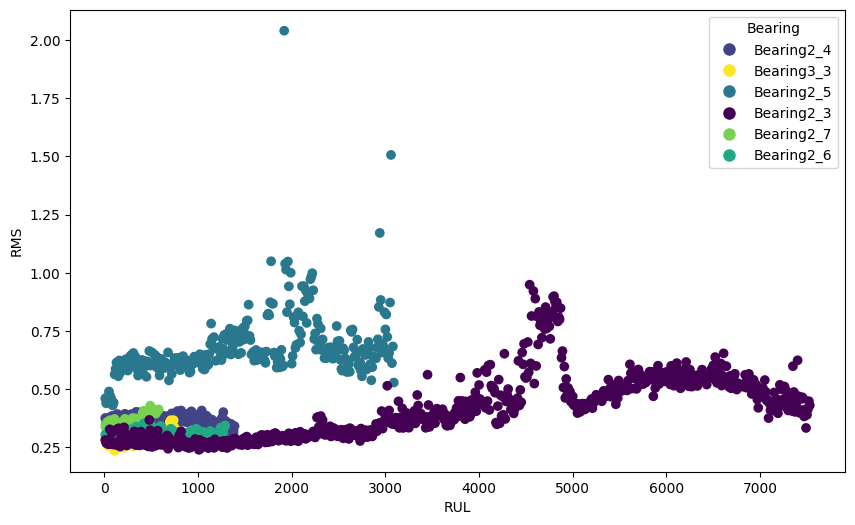

In [ ]:
FS_aux.plot_indicator_vs_indicator(indicators_alive,'RUL', 'RMS')

However, this is slow and does not scale well when he have many indicators.

How could we simplify that search?

We have already seen some ways of evaluating features for specific purposes, you have some examples [in this paper](https://www.sciencedirect.com/science/article/pii/S0004370222000078).

Fron the metrics they suggest we will focus on the **monotonicity** and **trendability**.



## Monotonicity

Monotonicity is rather simple to understand: It measures to which extent an indicator follows a increasing/decreasing trend over time.



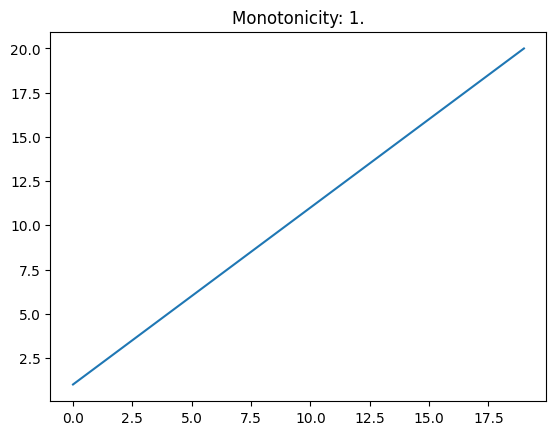

In [ ]:
increasing = np.arange(1, 21)

FS_aux.compute_monotonicity(increasing)

### Question

3) Using FS_aux.compute_monotonicity, would you tell me which curves of the following dictionary are monotonic?

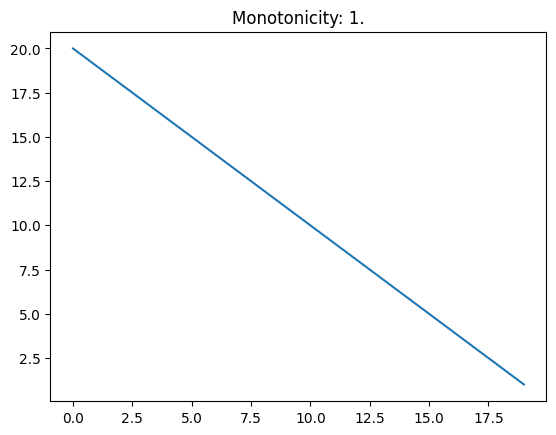

In [ ]:
curves = {
    'Curve1': np.arange(20, 0, -1),
    'Curve2': np.random.permutation(np.arange(1, 21)),
    'Curve3': np.sort(np.random.choice(np.arange(1, 11), 20, replace=True)),
    'Curve4': np.sort(np.random.choice(np.arange(1, 11), 20, replace=True))[::-1],
    'Curve5': -1 * (np.arange(-10, 11) ** 2) + 100,  # Vertex at (0, 100)
    'Curve6': -1 * (np.arange(0, 11) ** 2) + 100  # Only increasing part
}

FS_aux.compute_monotonicity(curves['Curve1'])

### Trendability

Trendability quite a trickier concept, according to the definition on the paper it means: "the extent to which the predictor displays the same shape across a group of units. It is a measure of similarity between all the damage trajectories of the population of units."

Basically, it takes the Pearson's correlation between all units (bearings in this case) for a feature, and takes the minimum value. That is, it penalizes the lack of repetitiveness between untis (bearings).

### Pearson's Correlation

Before going into detail with the trendability, let's understand first Pearson's correlation.

**Pearson's correlation** measures the linear correlation between two sets of data.

The following image from wikipedia (DenisBoigelot, original uploader was Imagecreator, CC0, via Wikimedia Commons) provides a good intuition of the correlation.
It goes from -1 to 1. Negative meaning one variable increases when the other decreases, 0 meaning no linear relation among variables and 1 meaning both increse at the same time.

![image.png](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)





However, how realiable is correlation?
Lets study the Anscombe's quartet dataset. A dataset that was built to create awareness of the limitations of correlation...



In [ ]:
anscombe = pd.read_json('../sample_data/anscombe.json') # ctrl + click to open the file in the editor

# Display the data
print(anscombe.head())

  Series   X     Y
0      I  10  8.04
1      I   8  6.95
2      I  13  7.58
3      I   9  8.81
4      I  11  8.33


The dataset has two variables X and Y and 4 different groups identified as Series. If we compute the correlation between X and Y in each group...

In [ ]:
from scipy.stats import pearsonr

anscombe.groupby('Series').apply(lambda group: pearsonr(group['X'], group['Y'])[0])

Series
I      0.816186
II     0.816237
III    0.816287
IV     0.816521
dtype: float64

They are equal! Even if the data is absolutely unrelated in each group.
However, how does the actual data look like?



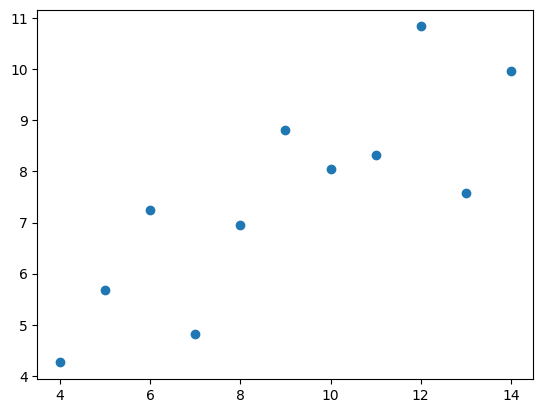

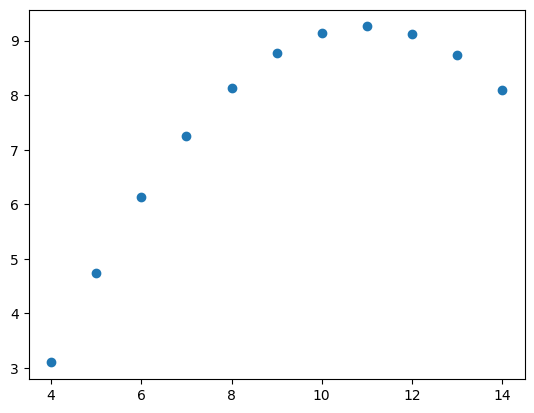

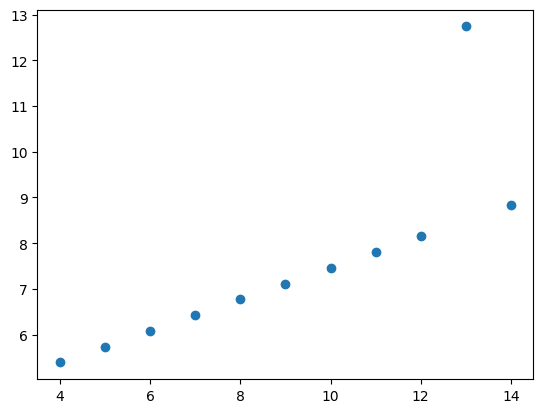

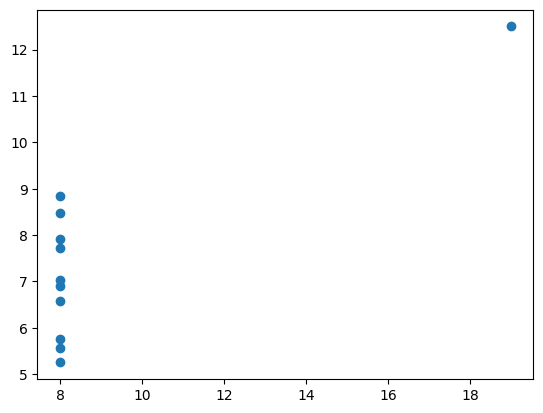

Series
I      (<matplotlib.collections.PathCollection object...
II     (<matplotlib.collections.PathCollection object...
III    (<matplotlib.collections.PathCollection object...
IV     (<matplotlib.collections.PathCollection object...
dtype: object

In [ ]:
import matplotlib.pyplot as plt
anscombe.groupby('Series').apply(lambda group: (plt.scatter(group['X'], group['Y']  ), plt.show()))

### Questions

4) What can you tell me about the effect of outliers on the correlation and about the risk of not checking the actual data?

### Back to trendability

As we mentioned, trendability relies on the minimum correlation for a feature between units.
So, for computing the trendability of an indicator we need to:

1) Compute the correlation between each pair of units (Bearings)

2) Identify the minimum value

However, there is a small problem here...

Bearings do not have the same data length, hence, it is not possible to directly compute the correlation. There is a 0) Step, that involves obtaining bearing vectors of the same length.

Even though in the paper they suggest doing interpolation, I have preffered to leave the data untouched. Instead, I suggest to take the same RUL rows for all the bearings, for that I have computed the bearing with the smallest RUL and created a vector with this value used to index the rest of bearings.

In [ ]:


indicators_alive.groupby('Bearing')['Origin'].count()

Bearing
Bearing2_3    753
Bearing2_4    139
Bearing2_5    309
Bearing2_6    129
Bearing2_7     58
Bearing3_3     82
Name: Origin, dtype: int64

In [ ]:
# Creating a RUL index vector
homoidexRUL = np.arange(0,579,25)  # 579 is used as result of: indicators.groupby('Bearing')['RUL'].agg(lambda x: np.max(x[x>0])) the smallest maxRUL from among the berings

# Reducing the indicator dataset to inly the values closest to the index
correlation_df = indicators_alive.groupby('Bearing').apply(lambda x: FS_aux.substract_homogeneous_RUL_values(x, homoidexRUL)).reset_index(level='Bearing', drop=True).copy()

In [ ]:
# Checking all bearings are of the same length
correlation_df.groupby('Bearing')['Origin'].count()

Bearing
Bearing2_3    24
Bearing2_4    24
Bearing2_5    24
Bearing2_6    24
Bearing2_7    24
Bearing3_3    24
Name: Origin, dtype: int64

Once our new dataset correlation_df is ready, we can compute the trendability for the different indicators.

Use the following two functions for that purpose

In [ ]:
FS_aux.compute_lowest_correlation(correlation_df, 'RMS')

(0.015069818719078558, ('Bearing2_3', 'Bearing2_7'))

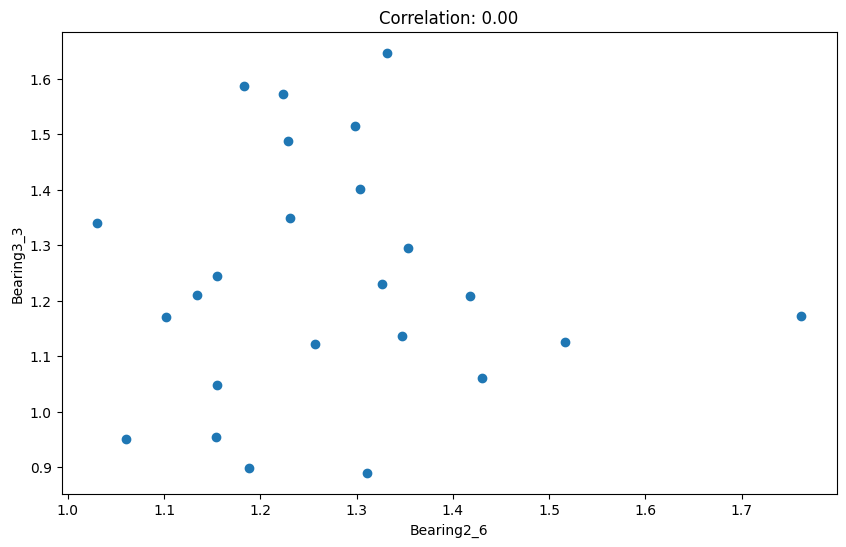

In [ ]:
FS_aux.plot_lowest_correlation(correlation_df, 'Peak')

## Questions

5) Identify the top 3 indicators (use code) for trendability and monotonicity.

6) Graphically verify some of them (draw the plots)